In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# scale our data
from sklearn.preprocessing import StandardScaler

# import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# import Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
accident_info = pd.read_csv('../uk-road-safety-accidents-and-vehicles/Accident_Information.csv')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vehicle_info = pd.read_csv('../uk-road-safety-accidents-and-vehicles/Vehicle_Information.csv', encoding = "ISO-8859-1")

In [4]:
accident_info.Date = pd.to_datetime(accident_info.Date)
accident_info.shape

(2047256, 34)

In [5]:
dd = accident_info[['Date', 'Accident_Severity']]

In [6]:
df2 = dd.set_index('Date').resample('W').size()

In [7]:
new_df = pd.Series(df2.values, df2.index)

In [8]:
train_size = int(len(new_df) * 0.80)
train, test = new_df[0:train_size], df2[train_size:]

x_train = np.array(train.index).reshape(-1, 1)#.astype('float64')
y_train = np.array(train.values.flatten()).reshape(-1, 1)
x_test = np.array(test.index).reshape(-1, 1)#.astype('float64')
y_test = np.array(test.values.flatten()).reshape(-1, 1)

In [9]:
expo_model = ExponentialSmoothing(trend='add',endog=train)
model_expo_fit = expo_model.fit(smoothing_level=0.05, smoothing_slope=0.002)

In [10]:
y1 = model_expo_fit.predict(start='2015-05-31', end='2017-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [11]:
train.tail()

Date
2015-04-26    2817
2015-05-03    2716
2015-05-10    2538
2015-05-17    2841
2015-05-24    2716
Freq: W-SUN, dtype: int64

In [12]:
mape1 = np.mean(np.abs((y1.values - test.values) / test.values)) * 100

In [13]:
mape1

7.442888008419632

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


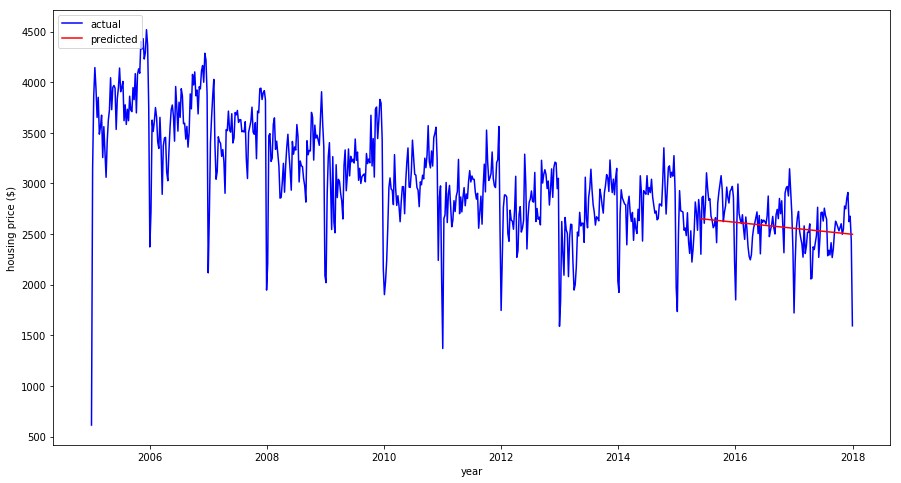

In [14]:
plt.figure(figsize=(15,8))
plt.plot(new_df.index, new_df.values.flatten(), '-b')
plt.plot(x_test, y1.values, '-r')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [15]:
model = SARIMAX(train,order = (2, 0, 3),seasonal_order = (3,1,2, 6),enforce_stationarity = False, enforce_invertibility = False)
model_fit = model.fit(disp=False)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
yhat = model_fit.get_prediction(start='2015-05-31', end='2017-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [17]:
mape2 = np.mean(np.abs((yhat.predicted_mean - test.values) / test.values)) * 100

In [18]:
mape2

7.711208653104554

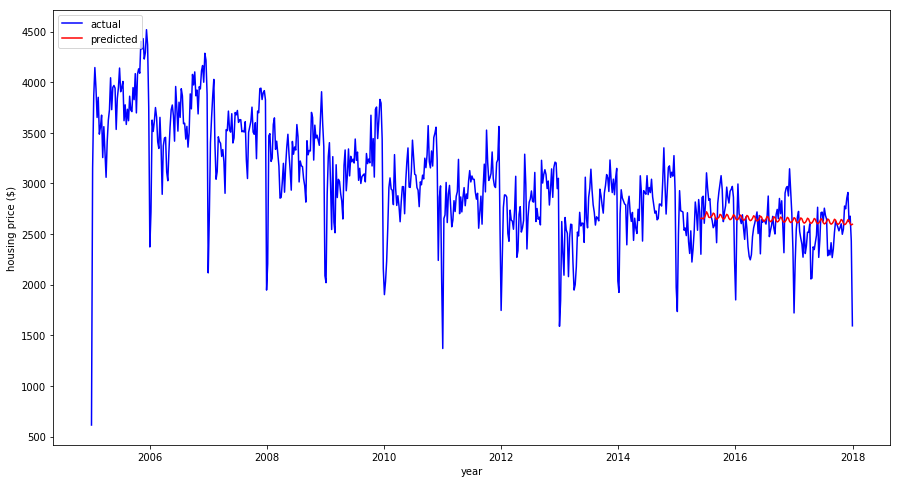

In [19]:
plt.figure(figsize=(15,8))
plt.plot(new_df.index, new_df.values.flatten(), '-b')
plt.plot(x_test, yhat.predicted_mean, '-r')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [20]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [21]:
model1 = ARIMA(endog=train, order=(1, 1, 1))

In [22]:
model_fit_1 = model1.fit(disp=False)

In [23]:
yhat_1 = model_fit_1.predict(start='2015-05-31', end='2017-12-31', typ='levels')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [24]:
mape3 = np.mean(np.abs((yhat_1 - test.values) / test.values)) * 100

In [25]:
mape3

10.186529701195584

In [28]:
serious = dd[dd['Accident_Severity']=='Serious']
slight = dd[dd['Accident_Severity']=='Slight']

serious = serious.set_index('Date').resample('W').size()
slight = slight.set_index('Date').resample('W').size()

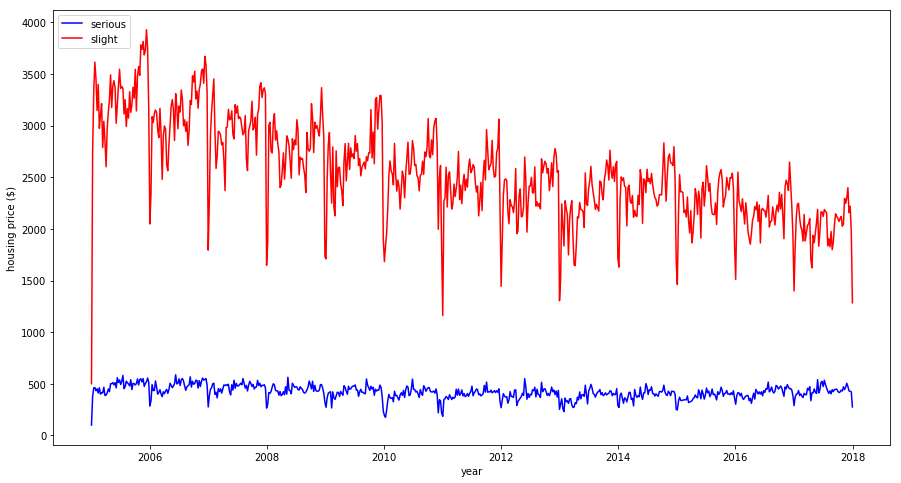

In [34]:
plt.figure(figsize=(15,8))
plt.plot(serious, '-b')
plt.plot(slight, '-r')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['serious', 'slight'], loc='upper left')
plt.show()